In [1]:
from __init__ import * 
import __template__new as mcj
import numpy as np
import argparse
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
          'font.size': 20,
          'figure.figsize': (16, 9),
          'axes.grid': False,
          'grid.linestyle': '-',
          'grid.alpha': 0.2,
          'lines.markersize': 5.0,
          'xtick.minor.visible': True,
          'xtick.direction': 'in',  
          'xtick.major.size': 10.0,
          'xtick.minor.size': 5.0,
          'xtick.top': True,
          'ytick.minor.visible': True,
          'ytick.direction': 'in',
          'ytick.major.size': 10.0,
          'ytick.minor.size': 5.0,
          'ytick.right': True,
          'errorbar.capsize': 0.0,
          'figure.max_open_warning': 50,
})
from scipy.optimize import curve_fit
import yaml
from iminuit import Minuit
from iminuit.cost import LeastSquares
import importlib



with open('yaml/data.yaml', 'r') as file:
    runs_info = yaml.safe_load(file)
    
make_dir('Hardware_Fit')
make_dir('Hardware_Fit/parqs')
make_dir('Hardware_Fit/figures')
make_dir('npys')
make_dir('parqs')
make_dir('generic_figures')


"La cartella 'generic_figures' esiste già."

In [2]:
import random

In [3]:
crystal = 'BGO'
beam = 'e'
angle = 180
ch = 1
laser = True

In [4]:
beam_text = r'$e^+$' if beam == 'e' else r'$\mu^+$'

In [5]:
print(f'Running script for {crystal} with {beam} at {angle} degrees')
if not laser:
    print('Template from analytic function')
else:
    print('Template from Laser Calibration Waveform')

Running script for BGO with e at 180 degrees
Template from Laser Calibration Waveform


In [6]:
mean =  {}
df = {}

In [ ]:
print(f'Reading Files')
wf, df = mixing_run(runs_info[crystal][beam][angle], addLyso=True)
times = wf[0]['times']

Reading Files
0


 83%|████████▎ | 2981/3595 [00:02<00:00, 1320.49it/s]

KeyboardInterrupt: 

 85%|████████▍ | 3048/3595 [00:21<00:00, 1320.49it/s]

In [33]:
wf[0].keys()

dict_keys(['1media', '2media', 'times'])

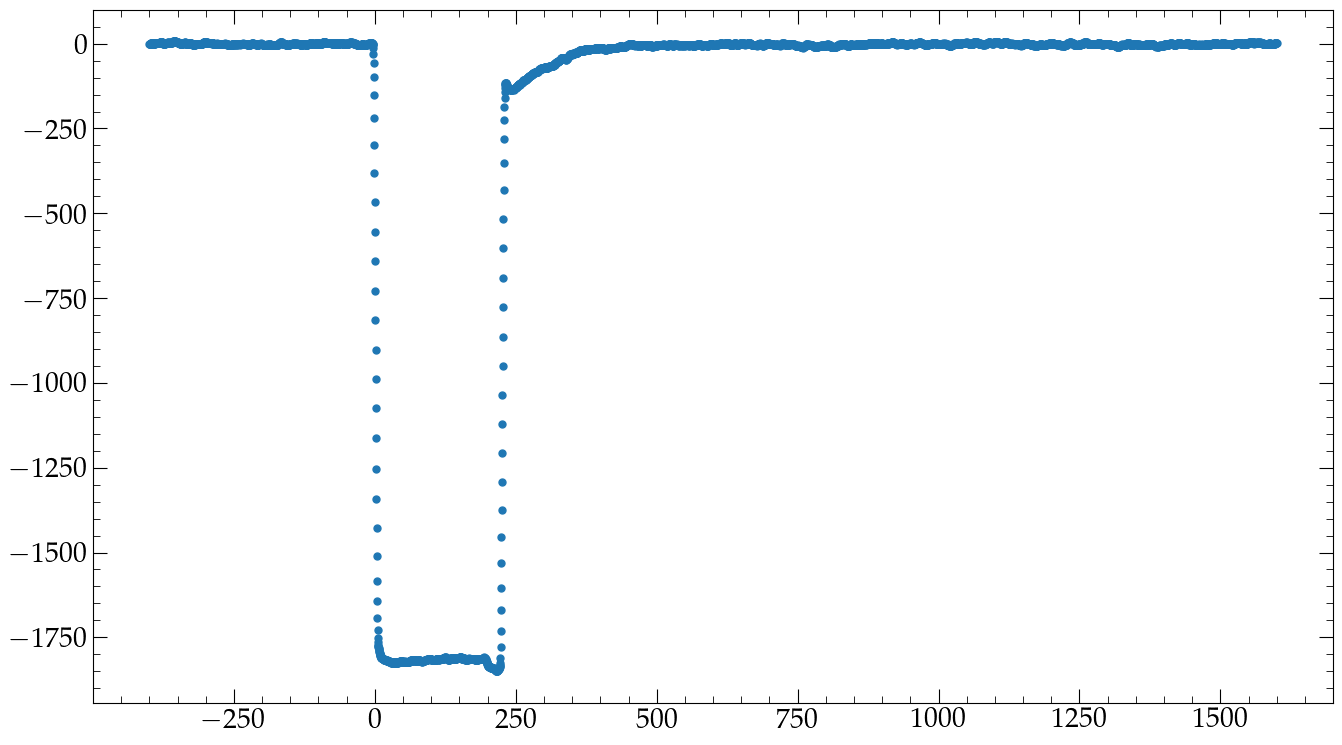

In [10]:
plt.scatter(times, wf[0]['3media'])

In [41]:
df[f'amplitude_media_channel{ch}'] = df[f'amplitude_media_channel{ch}'].fillna(0)

In [9]:
with open('yaml/laser_calib.yaml', 'r') as file:
    log_laser = yaml.safe_load(file)

In [22]:
def get_sipm_ampl(ch, crystal):
    if ch == 2:
        sipm = '6x6' 
        ampl = 18
        
    if ch == 1:
        sipm = '3x3' 
        ampl = 0 if crystal == 'BGO' else 18
        
    if sipm == '3x3':
        if ampl == 0:
            SPR = mcj.ampl3x3_filter 
        elif ampl == 18:
            SPR = mcj.ampl3x3_18
        elif ampl == 28:
            SPR = mcj.ampl3x3_28
            
    if sipm == '6x6':
        if ampl == 18:
            SPR = mcj.ampl6x6_18
        if ampl == 28:
            SPR = mcj.ampl6x6_28
    return SPR, sipm, ampl

In [11]:
if laser:
    path_data = '/eos/user/m/mcampajo/MAXICC_TB_analysis/data_calibrazioni/laser/'
    create_mean_wf(log_laser[sipm][ampl], path_data)

I file npys/Times_483.npy e npys/Mean_Waveform_483.npy esistono già


In [12]:
ev_ids = df.query(f'amplitude_media_channel{ch} > 25')['__event__']
ev_ids = ev_ids.to_list()

sampled_numbers = random.sample(ev_ids, 10)

print(sampled_numbers)



[10889, 17706, 8957, 14289, 23174, 23640, 15696, 581, 22155, 21251]


In [ ]:
dt = times[1]-times[0]
ranger = [int(times.min()), int(times.max())]
npoints = len(times)

In [14]:
def myfunc(x, c, s, t0, of):
    return mcj.wf_function(x, interS_template, interC_template, c, s, t0, of)

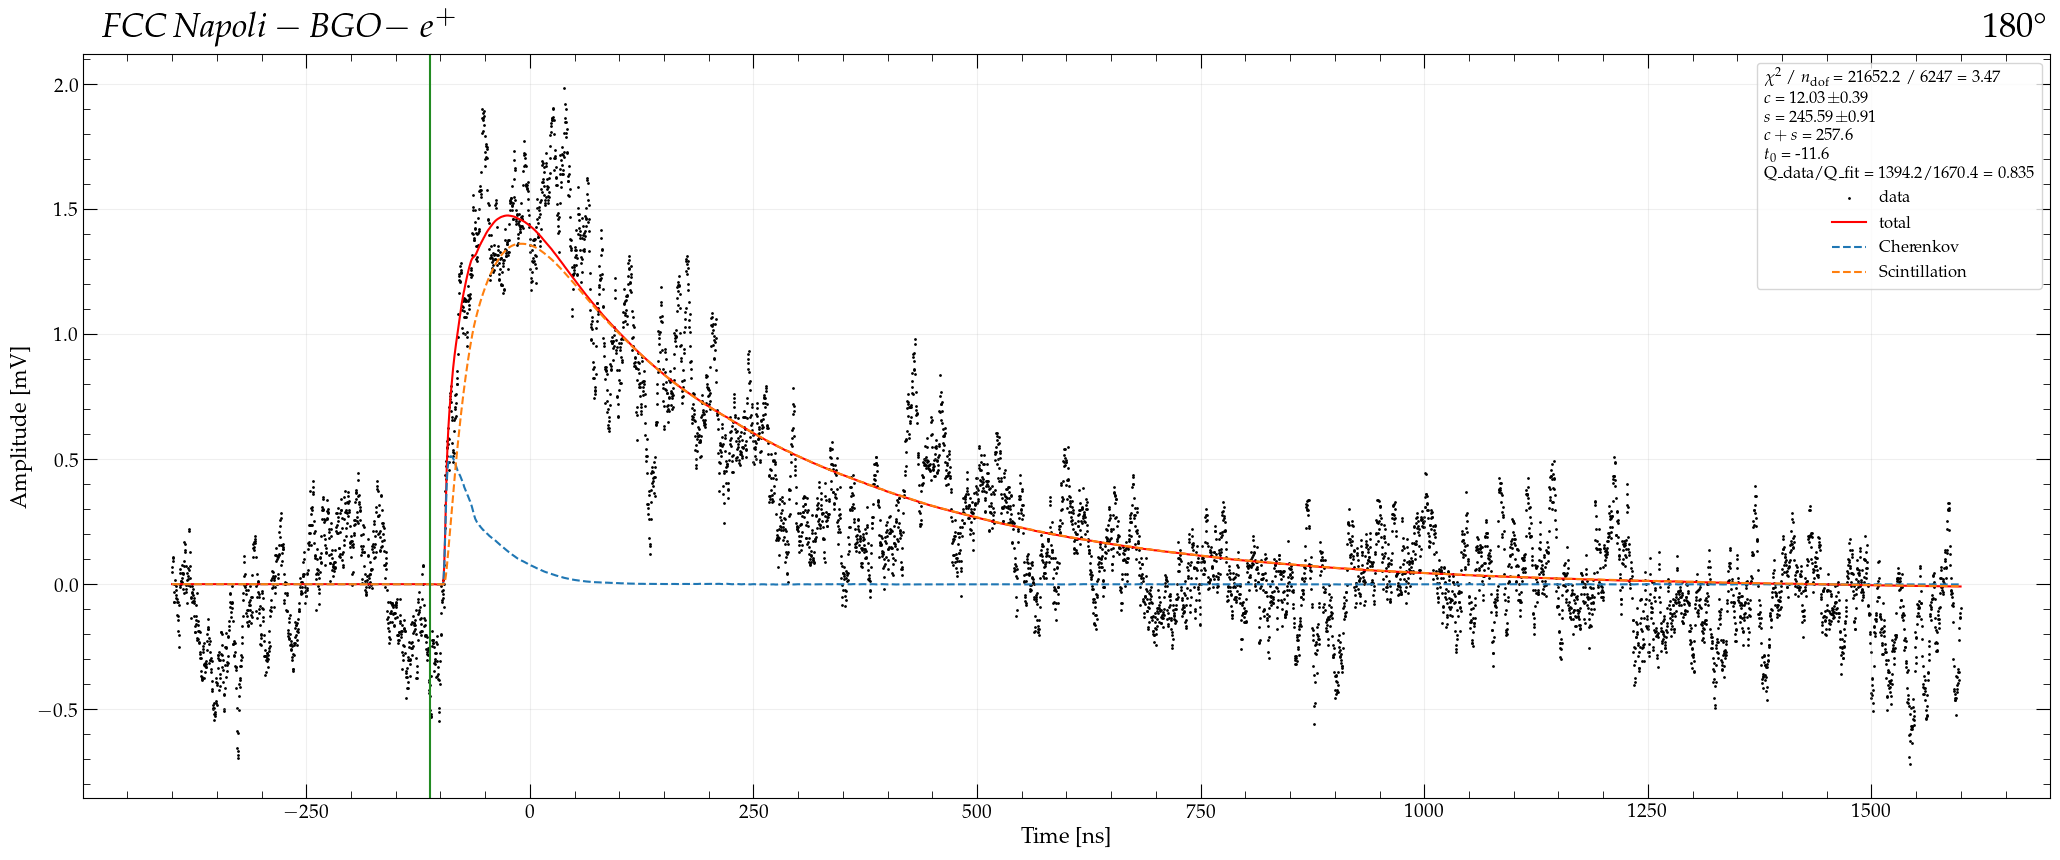

In [56]:
ch = 1
SPR, sipm, ampl = get_sipm_ampl(ch, crystal)
interS_template, interC_template, bins = mcj.get_templates(crystal,
                                                        sipm,
                                                        SPR,
                                                        ranger,
                                                        dt,
                                                        nsimS=1E7,
                                                        nsimC=1E7,
                                                        normalize=True,
                                                        graphics=False,
                                                        Laser_Calib = laser, 
                                                        run = log_laser[sipm][ampl])
for ev_id in [23355]:
    WFT = wf[ev_id][f'{ch}media']

    sigmas = np.std(WFT[:100])

    if len(times) != len(WFT):
        continue
    least_squares = LeastSquares(times, WFT, sigmas, myfunc)
    m = Minuit(least_squares, 100, 100, 0, 0)
    m.fixed['of'] = True
    m.migrad() 

    fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fval/m.ndof:.2f} \n \
                $c$ = {m.values['c']:.2f}$\pm${m.errors['c']:.2f} \n \
                $s$ = {m.values['s']:.2f}$\pm${m.errors['s']:.2f} \n  \
                $c+s$ = {(m.values['c'] + m.values['s']):.1f} \n  \
                $t_0$ = {m.values['t0']:.1f} \n  \
                Q_data/Q_fit = {np.sum(WFT):.1f}/{np.sum(myfunc(times, *m.values)):.1f} = {np.sum(WFT)/np.sum(myfunc(times, *m.values)):.3f}" ]

    try:
        # Create mask for times less than (t0 - 100)
        mask = times < (m.values['t0'] - 100)
        # Extract relevant data
        relevant_data = WFT[mask]
        
        # Check if there are any values selected
        if relevant_data.size > 0:
            ampl_sideband = np.max(relevant_data)
        else:
            ampl_sideband = 0
    except (IndexError, ValueError, TypeError) as e:
        # Handle specific exceptions
        ampl_sideband = 0
        print(f"Error: {e}")

    custom_plot_layout(title = f'', xlabel=r"Time [ns]", figsize = (21,9), angle = angle, crystal = crystal, beam = beam_text)
    plt.scatter(times, WFT, s=1, color='black', label="data")
    plt.plot(times, myfunc(times, *m.values), label="total", color='red')
    plt.plot(times, myfunc(times, m.values['c'], 0, m.values['t0'], m.values['of']), label="Cherenkov", color='C0', linestyle='--')
    plt.plot(times, myfunc(times, 0, m.values['s'], m.values['t0'], m.values['of']), label="Scintillation", color='C1', linestyle='--')
    plt.axvline(-100+m.values['t0'], color = 'forestgreen')

    plt.legend(title="\n".join(fit_info), fontsize=12, title_fontsize=12)
    plt.xlabel('Time [ns]', fontsize=16)
    plt.ylabel('Amplitude [mV]', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.title(f'BGO - 10GeV e+ - theta={theta}, run {run_index}, event {event} ', size=16)
    #plt.axvline(x=m.values['x0'])
    plt.grid()
    plt.tight_layout()
    #plt.xlim(-150, 50)
    plt.savefig(f'PaperFigures/Example_LowAmpls_{ev_id}_{crystal}_{beam}_{angle}_{ch}.png', dpi = 300)
    plt.show()


In [25]:
(m.values['s'])/9000

1.7261623996589646

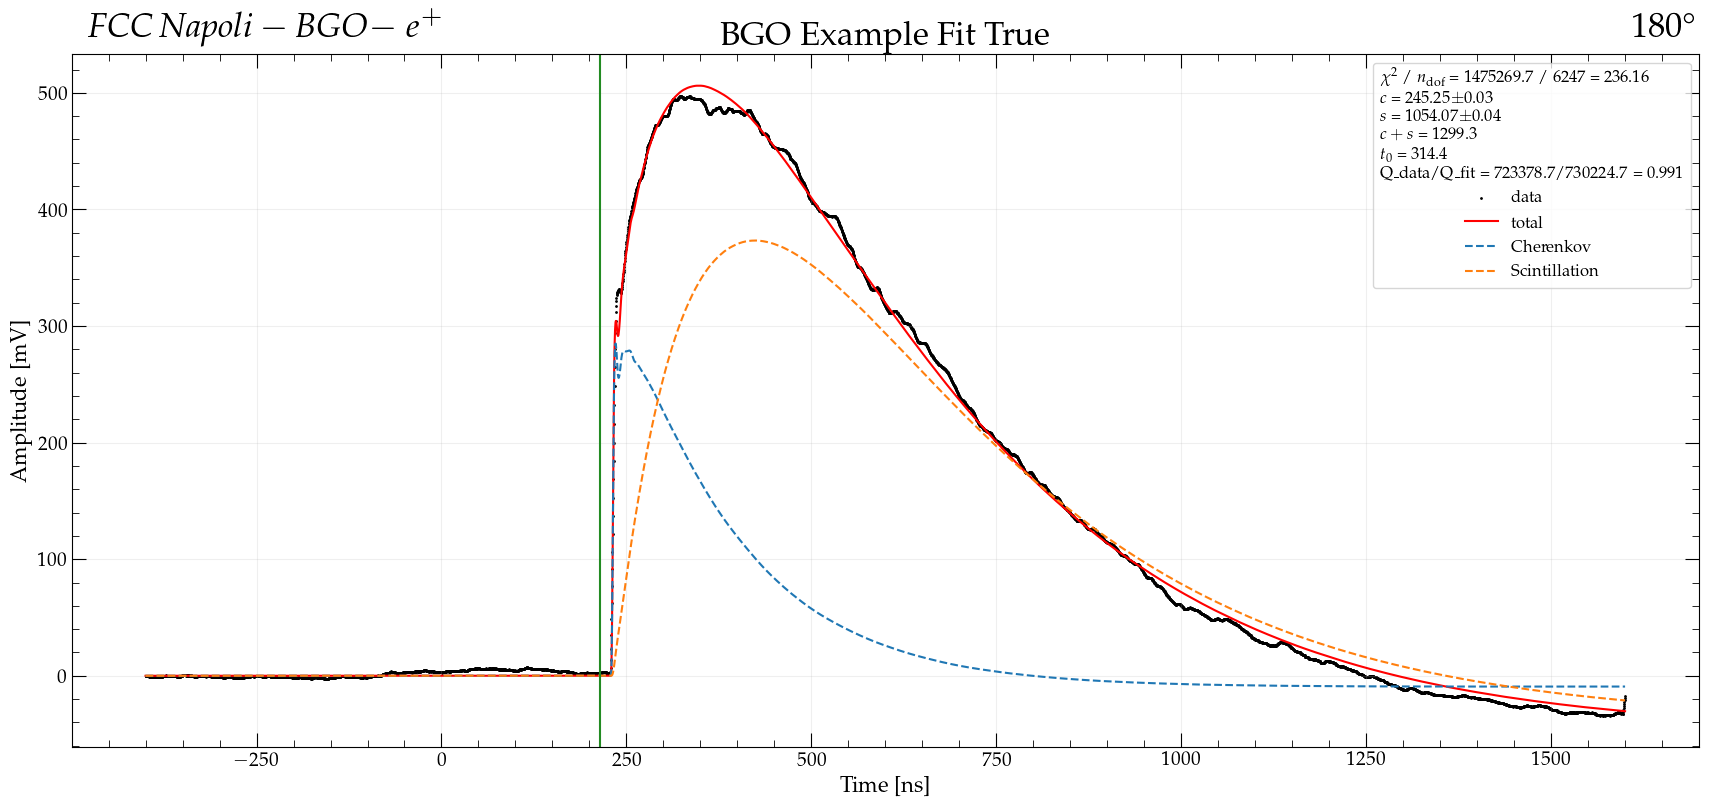

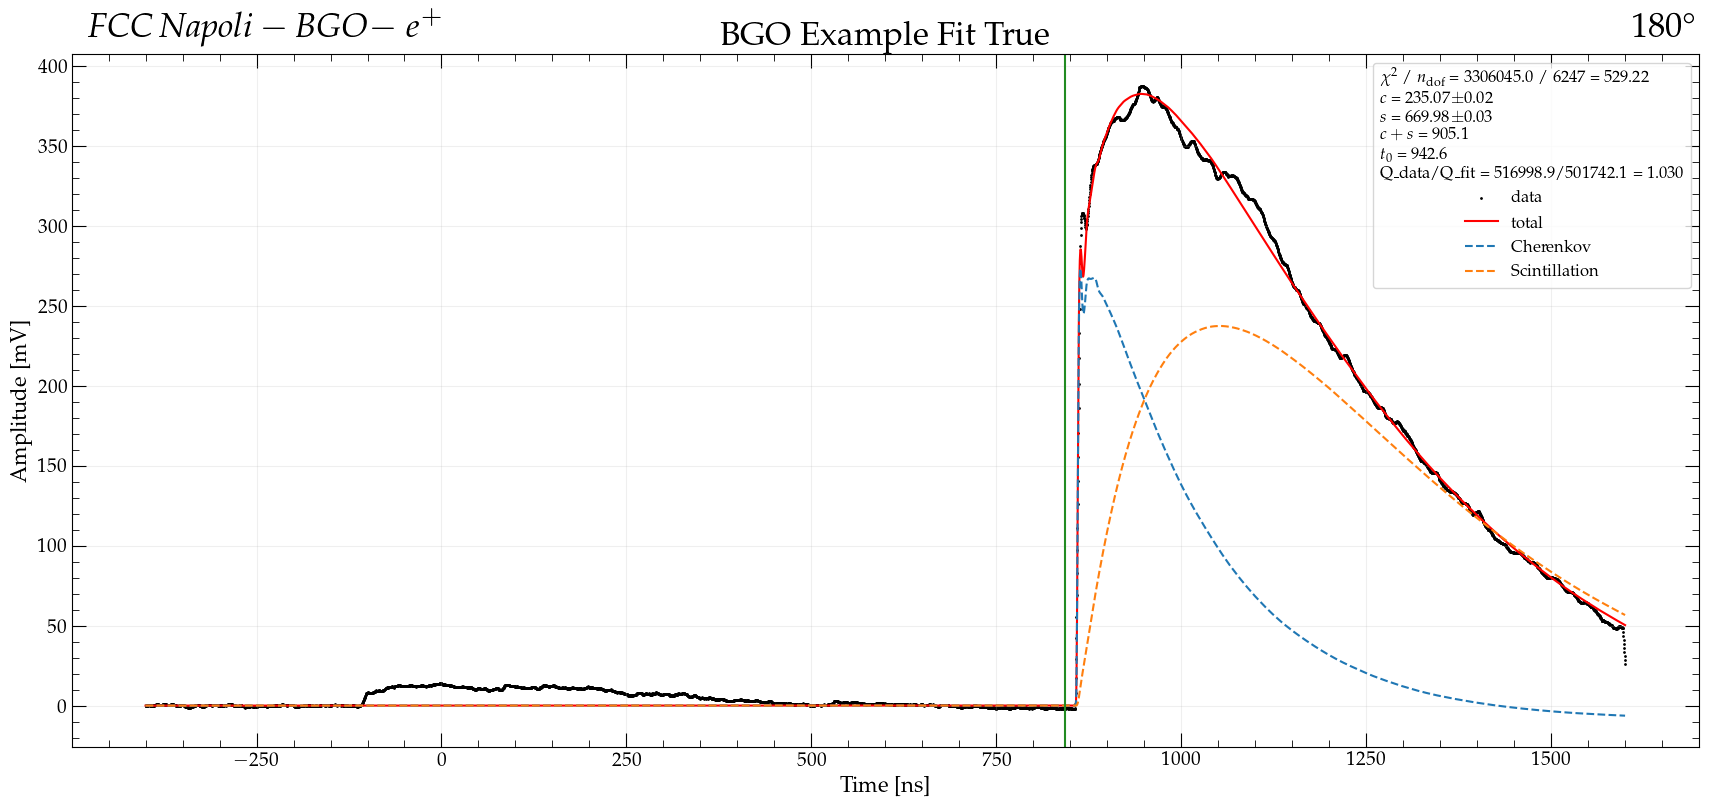

In [30]:
ch = 2
SPR, sipm, ampl = get_sipm_ampl(ch, crystal)
interS_template, interC_template, bins = mcj.get_templates(crystal,
                                                        sipm,
                                                        SPR,
                                                        ranger,
                                                        dt,
                                                        nsimS=1E7,
                                                        nsimC=1E7,
                                                        normalize=True,
                                                        graphics=False,
                                                        Laser_Calib = laser, 
                                                        run = log_laser[sipm][ampl])
for ev_id in [7663, 9496]:
    WFT = wf[ev_id][f'{ch}media']

    sigmas = np.std(WFT[:100])

    if len(times) != len(WFT):
        continue
    least_squares = LeastSquares(times, WFT, sigmas, myfunc)
    m = Minuit(least_squares, 100, 100, 0, 0)
    m.fixed['of'] = True
    m.migrad() 

    fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fval/m.ndof:.2f} \n \
                $c$ = {m.values['c']:.2f}$\pm${m.errors['c']:.2f} \n \
                $s$ = {m.values['s']:.2f}$\pm${m.errors['s']:.2f} \n  \
                $c+s$ = {(m.values['c'] + m.values['s']):.1f} \n  \
                $t_0$ = {m.values['t0']:.1f} \n  \
                Q_data/Q_fit = {np.sum(WFT):.1f}/{np.sum(myfunc(times, *m.values)):.1f} = {np.sum(WFT)/np.sum(myfunc(times, *m.values)):.3f}" ]

    try:
        # Create mask for times less than (t0 - 100)
        mask = times < (m.values['t0'] - 100)
        # Extract relevant data
        relevant_data = WFT[mask]
        
        # Check if there are any values selected
        if relevant_data.size > 0:
            ampl_sideband = np.max(relevant_data)
        else:
            ampl_sideband = 0
    except (IndexError, ValueError, TypeError) as e:
        # Handle specific exceptions
        ampl_sideband = 0
        print(f"Error: {e}")

    custom_plot_layout(title = f'{crystal} Example Fit {laser}', xlabel=r"Time [ns]", figsize = (21,9), angle = angle, crystal = crystal, beam = beam_text)
    plt.scatter(times, WFT, s=1, color='black', label="data")
    plt.plot(times, myfunc(times, *m.values), label="total", color='red')
    plt.plot(times, myfunc(times, m.values['c'], 0, m.values['t0'], m.values['of']), label="Cherenkov", color='C0', linestyle='--')
    plt.plot(times, myfunc(times, 0, m.values['s'], m.values['t0'], m.values['of']), label="Scintillation", color='C1', linestyle='--')
    plt.axvline(-100+m.values['t0'], color = 'forestgreen')

    plt.legend(title="\n".join(fit_info), fontsize=12, title_fontsize=12)
    plt.xlabel('Time [ns]', fontsize=16)
    plt.ylabel('Amplitude [mV]', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.title(f'BGO - 10GeV e+ - theta={theta}, run {run_index}, event {event} ', size=16)
    #plt.axvline(x=m.values['x0'])
    plt.grid()
    #plt.xlim(-150, 50)
    #plt.savefig(f'generic_figures/Example_Fit{crystal}_{beam}_{angle}_{ch}.png', dpi = 300)
    plt.show()
